In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from statistics import mean
from torch.autograd import Variable
import time
from PIL import Image
import random
from skimage import io, transform
from collections import OrderedDict
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from matplotlib import pyplot as plt
from skimage import io, transform
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Any results you write to the current directory are saved as output.

In [11]:
# Any results you write to the current directory are saved as output.
csv_path =  '/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/data.csv'
data_folder = os.getcwd().replace("/img-segmentation/unet_rhina2", "") + '/dataset/sagittal/all-augmented'
eg_path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809'
eg_img = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_10.tif'
eg_mask = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_10_mask.tif'

In [36]:
class Brain_data(Dataset):
    def __init__(self,path):
        self.path = path
        self.masks,self.images = [],[]

        for file in os.listdir(path):
            if '_mask_a' in file.split('.')[0]:
                self.masks.append(os.path.join(self.path,file))
            elif '_a' in file.split('.')[0]:
                self.images.append(os.path.join(self.path,file)) 
            elif '_mask' in file.split('.')[0]:
                self.masks.append(os.path.join(self.path,file)) 
            elif 'img' in file.split('.')[0]:
                self.images.append(os.path.join(self.path,file)) 
            else:
                print("File is invalid.")

        self.images = sorted(self.images, key=lambda string: string.split('/')[-1].strip("img").split('.')[0].strip('_a'))
        self.images = sorted(self.images, key=lambda string: int(string.split('/')[-1].split('_')[0].strip('img').strip('.png')))

        self.masks = sorted(self.masks, key=lambda string: string.split('/')[-1].strip("img").split('.')[0].strip('_mask_a'))
        self.masks = sorted(self.masks, key=lambda string: int(string.split('/')[-1].split('_')[0].strip('img').strip('.png')))

        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image = self.images[idx]
        mask = self.masks[idx]

        image = io.imread(image)
        image = transform.resize(image,(256,256))
        image = image / 255
        image = image.transpose((2, 0, 1))
        
        
        mask = io.imread(mask)
        mask = transform.resize(mask,(256,256))
        mask = mask / 255
        mask = mask.transpose((2, 0, 1))

        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)
        
        return (image,mask)

In [37]:
data = Brain_data(data_folder)
print('Length of dataset is {}'. format(data.__len__()))
print('sample data: ')
data.__getitem__(0)

Length of dataset is 1062
sample data: 


(tensor([[[2.8989e-03, 2.8989e-03, 2.8989e-03,  ..., 2.9681e-03,
           2.9681e-03, 2.9681e-03],
          [2.8220e-03, 2.8220e-03, 2.8220e-03,  ..., 2.8374e-03,
           2.8374e-03, 2.8374e-03],
          [2.1376e-03, 2.1376e-03, 2.1376e-03,  ..., 2.1607e-03,
           2.1607e-03, 2.1607e-03],
          ...,
          [8.4583e-05, 8.4583e-05, 8.4583e-05,  ..., 8.4583e-05,
           8.4583e-05, 8.4583e-05],
          [1.4533e-03, 1.4533e-03, 1.4533e-03,  ..., 1.4533e-03,
           1.4533e-03, 1.4533e-03],
          [3.2065e-03, 3.2065e-03, 3.2065e-03,  ..., 3.2065e-03,
           3.2065e-03, 3.2065e-03]],
 
         [[2.8989e-03, 2.8989e-03, 2.8989e-03,  ..., 2.9681e-03,
           2.9681e-03, 2.9681e-03],
          [2.8220e-03, 2.8220e-03, 2.8220e-03,  ..., 2.8374e-03,
           2.8374e-03, 2.8374e-03],
          [2.1376e-03, 2.1376e-03, 2.1376e-03,  ..., 2.1607e-03,
           2.1607e-03, 2.1607e-03],
          ...,
          [8.4583e-05, 8.4583e-05, 8.4583e-05,  ..., 8.458

In [38]:
# checking shape of data
for img,msk in data:
      print(img.shape)
      print(msk.shape)
      break

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


In [47]:
# splitting to trainset and validation set
length = data.__len__()
train_length = int(length*0.8)+1
val_length = int(length*0.2)

trainset, valset = random_split(data, [train_length, val_length])
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=10,shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=valset, batch_size=10)

In [52]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255)
    return image

def mask_convert(mask):
    mask = mask.clone().cpu().numpy()
    mask = mask.transpose((1,2,0))
    mask = (mask * 255)
    return mask

def plot_img(no_):
    iter_ = iter(train_loader)
    images, masks = next(iter_)
    images = images.to(device)
    masks = masks.to(device)
    plt.figure(figsize=(20,10))
    for idx in range(0,no_):
         image = image_convert(images[idx])
         plt.subplot(2,no_,idx+1)
         plt.imshow(image)
    for idx in range(0,no_):
         mask = mask_convert(masks[idx])
         plt.subplot(2,no_,idx+no_+1)
         plt.imshow(mask)
    plt.show()

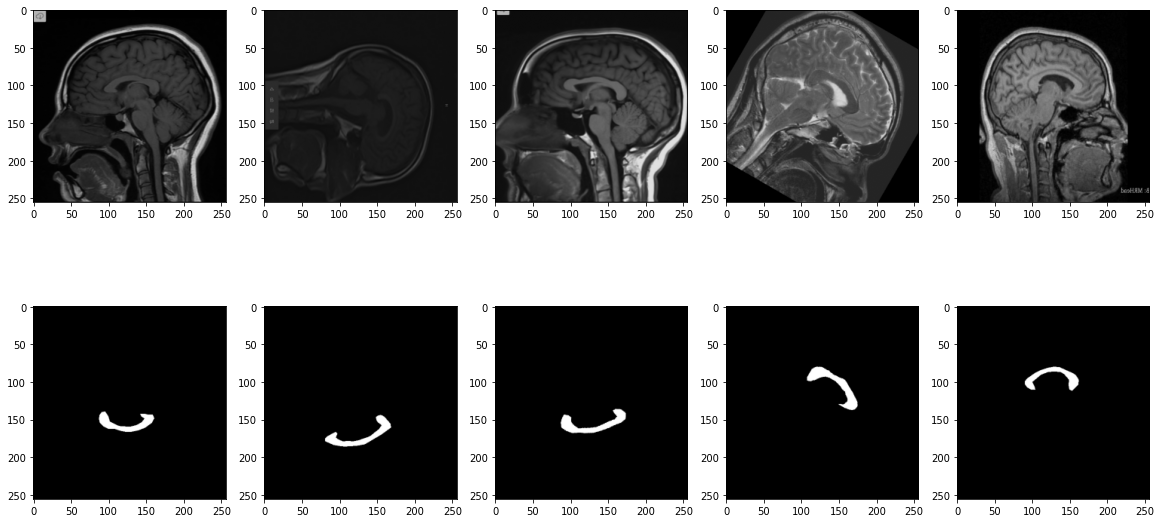

In [53]:
plot_img(5)

In [54]:


class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=(3,3),padding=1):
        super(ConvBlock,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size,padding=padding,bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels,eps=1e-4)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x
        
        
class StackEncoder(nn.Module):
    def __init__(self,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackEncoder,self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.block = nn.Sequential(
            ConvBlock(channel1,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),     
        )
        
    def forward(self,x):
        big_out = self.block(x)
        poolout = self.maxpool(big_out)
        return big_out,poolout
     
        
class StackDecoder(nn.Module):
    def __init__(self,big_channel,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackDecoder,self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channel1+big_channel,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),
        )
        
    def forward(self,x,down_tensor):
            _, channels, height, width = down_tensor.size()  
            x = F.upsample(x, size=(height, width), mode='bilinear')
            x = torch.cat([x, down_tensor], 1)  #combining channels of  input from encoder and upsampling input
            x = self.block(x)
            return x
        
        
class Unet256(nn.Module):
    def __init__(self,input_shape):
        super(Unet256,self).__init__()
        
        channel,height,width = input_shape
        
        self.down1 = StackEncoder(channel,12,kernel_size=(3,3))  #256
        self.down2 = StackEncoder(12,24,kernel_size=(3,3))  # 128
        self.down3 = StackEncoder(24,46,kernel_size=(3,3))  # 64
        self.down4 = StackEncoder(46,64,kernel_size=(3,3))  # 32
        self.down5 = StackEncoder(64,128,kernel_size=(3,3))  #16
        
        self.center = ConvBlock(128,128,kernel_size=(3,3),padding=1) #16
        
        self.up5 = StackDecoder(128,128,64,kernel_size=(3,3))  #32
        self.up4 = StackDecoder(64,64,46,kernel_size=(3,3)) #64
        self.up3 = StackDecoder(46,46,24,kernel_size=(3,3))
        self.up2 = StackDecoder(24,24,12,kernel_size=(3,3))
        self.up1 = StackDecoder(12,12,12,kernel_size=(3,3))
        self.conv = Conv2d(12,1,kernel_size=(1,1),bias=True)
        
    def forward(self,x):
        down1,out = self.down1(x)  
        down2,out = self.down2(out)  
        down3,out = self.down3(out)
        down4,out = self.down4(out)
        down5,out = self.down5(out)
        
        
        out = self.center(out)
        
        up5 = self.up5(out,down5)
        up4 = self.up4(up5,down4)
        up3 = self.up3(up4,down3)
        up2 = self.up2(up3,down2)
        up1 = self.up1(up2,down1)
        
        out = self.conv(up1)


        return out
        

In [55]:
model = Unet256((3,256,256)).to(device)
model

Unet256(
  (down1): StackEncoder(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (block): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batchnorm): BatchNorm2d(12, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): ConvBlock(
        (conv): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batchnorm): BatchNorm2d(12, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
    )
  )
  (down2): StackEncoder(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (block): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batchnorm): BatchNorm2d(24, eps=0.0001, momentum=0.1, a

In [56]:


class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final
    
    

class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU * 100

    
    
class DiceScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceScore, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_score = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth) 
        return dice_score

In [57]:
criterion = DiceBCELoss()


learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [58]:
epochs = 25

train_loss = []
val_loss = []

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    start_time = time.time()
     
    running_train_loss = []
    
    for image,mask in train_loader: 
            image = image.to(device,dtype=torch.float)
            mask = mask.to(device,dtype=torch.float)
            
            pred_mask = model.forward(image) # forward propogation
            loss = criterion(pred_mask,mask)
            optimizer.zero_grad() # setting gradient to zero
            loss.backward()
            optimizer.step()
            running_train_loss.append(loss.item())
                              
    else:           
        running_val_loss = []
        
        with torch.no_grad():
            for image,mask in val_loader:
                    image = image.to(device,dtype=torch.float)
                    mask = mask.to(device,dtype=torch.float)                            
                    pred_mask = model.forward(image)
                    loss = criterion(pred_mask,mask)
                    running_val_loss.append(loss.item())
                    
    
    epoch_train_loss = np.mean(running_train_loss) 
    print('Train loss: {}'.format(epoch_train_loss))                       
    train_loss.append(epoch_train_loss)
    
    epoch_val_loss = np.mean(running_val_loss)
    print('Validation loss: {}'.format(epoch_val_loss))                                
    val_loss.append(epoch_val_loss)
                      
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch 1/25
/Users/rhina/Documents/GitHub/AKCSE-Medical-Image-Analysis/venv/lib/python3.8/site-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/Users/rhina/Documents/GitHub/AKCSE-Medical-Image-Analysis/venv/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/Users/rhina/Documents/GitHub/AKCSE-Medical-Image-Analysis/venv/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


RuntimeError: The size of tensor a (655360) must match the size of tensor b (1966080) at non-singleton dimension 0